# HW3

In the .csv file, we have some mock galaxys' information along the radius
- `R`: in the unit of arcsec, in the header of file it is written as Reff
- `mu`: in the unit of mag/arcsec^2, the surface brightness in a given R
- `mu`: the error of `mu`
- All these galaxies are in `D=200Mpc` away from us.

## **Todo**

1. Use Sersic profile to fit the point, show the `I0`, `Reff`, `n_index`
2. Determine the total luminosity of galaxy in terms of solar luminosity in r-band
3. What is the modulus distance

# Solution

## Q1

Sersic formular

$$I(R)=I_0exp[-\beta_n(\frac{R}{R_e})^{1/n}]=I_e exp[-\beta_n\{(\frac{R}{R_e})^{1/n}-1\}]$$

where $\beta_n=2n-0.324$, **n is decimal is ok**

Write in log:

$$\mu(R)=\mu_e+1.086\beta_n[(\frac{R}{R_e})^{1/n}-1]$$

where $\mu_e=-2.5log_{10}Ie$, $-2.5log_{10}e\approx1.086$

We can use `scipy.optimize.curve_fit` to fit the data. I write a func `get_sersic_params` to solve the fit. For more detail about this formular, [click here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).
- `curve_fit` use non-linear least squares to fit
  - If we don't consider the mu_err, the you should write something like `curve_fit(R,mu)` to get the fit. In this case the optimized function is $\Chi^2=\sum((y_{real}-y_{fit})^2)$
  - But we have the mu_err, so you'd better write someting like `curve_fit(R,mu,sigma=mu_err)` to get the fit. In this case the optimized function is $\Chi^2=\sum(((y_{real}-y_{fit})/(sigma))^2)$. 

## Q2

You need to use this formular to convert the `\mu_0` to `I_0`:
$$\mu_0-M_\odot-5log(D/10pc)=-2.5log(\frac{I_0}{L_{\odot}/arcsec^2})\tag{1}$$

Or you can use this one from the book *galaxy formation and evolution* Formular(2.8)
$$\mu_0=-2.5log(\frac{I_0}{L_\odot pc^{-2}})+21.572+M_\odot\tag{2}$$

It can be proved that (1) & (2) are exactly the same. I will show you in the appendix.

From the step above, we get the `I0` in the unit of $L_\odot/arcsec^2$ or $L_\odot/pc^2$. Then we can integrate the surface brightness (or the intensity) to get the total luminosity. Assuming spherically symmetric, the luminosity of sersic profile is analysable.
$$L=2\pi\int^\infty_0 I(R)RdR=\frac{2\pi n \Gamma(2n)}{\beta_n^{2n}} I_0 R^2_e$$

where $\Gamma(n)=n-1!$, $I_0=I_eexp(\beta_n)$

For (1), I write a func `get_lumi_from_I0_pc2`. For (2), I write a func `get_lumi_from_I0_arcsec2`.

## Q3 
This question is easy. Just remember the definition of **distance modulus = 5log(D/10pc)= apparant mag - Abs mag**



# The code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [14]:
def mu_R_func(R,Re,mu_e,n_sersic):
    beta_n=2*n_sersic-0.324
    # -2.5log10(e)\approx 1.086
    mu_R=mu_e+1.086*beta_n*((R/Re)**(1/n_sersic)-1)
    return mu_R

def get_sersic_params(loc_ls,consider_err=True,output=True,output_plot=False,*args,**kwargs):
    result=pd.DataFrame(columns=['Re','mu_e','n_sersic','mu_0'])
    for i in range(len(loc_ls)):
        data=pd.read_csv(loc_ls[i])

        if consider_err==True:
            popt, pcov=curve_fit(mu_R_func,data.Reff.values,data.mu.values,sigma=data.mu_err)
        else: 
            popt, pcov=curve_fit(mu_R_func,data.Reff.values,data.mu.values)

        result.loc[i,['Re','mu_e','n_sersic']]=popt
        # mu_0=mu_e-1.086*beta_n
        mu_0=popt[1]-(1.086*2*popt[2]-0.324)
        result.loc[i,'mu_0']=mu_0
        if output == True:
            print('{}:   R: {:.3f}, mu_e: {:.3f}, n_sersic: {:.3f}, mu_0: {:.3f}'.format(loc_ls[i],popt[0],popt[1],popt[2],mu_0))
        if output_plot == True:
            R=np.linspace(0,max(data.Reff.max(),20))
            mu=mu_R_func(R,popt[0],popt[1],popt[2])
            plt.figure(figsize=(8,6))
            fig,ax=plt.subplots(1,1)
            plt.errorbar(data.Reff.values,data.mu.values,data.mu_err.values)
            plt.plot(R,mu,label='Re = {:.2f}\n\nmu_e = {:.2f}\n\nn = {:.2f}'.format(popt[0],popt[1],popt[2]))
            plt.legend(loc='upper right')
            plt.xlabel('R/arcsec')
            plt.ylabel('$\mu(R)$/(mag/arcsec^2)')
            ax.invert_yaxis()
            plt.title(loc_ls[i])
            # plt.tight_layout()
    return result

def get_lumi_from_I0_pc2(data,output=True):
    # The unit of I0 is L_sun/pc^2
    lumi_ls=[]
    for i in range(len(data)):
        n,I0,Re=data.n_sersic.values[i],data.I0_pc2.values[i],data.Re_pc.values[i]
        beta_n=2*n-0.324
        L=2*np.pi*n*np.math.gamma(2*n)/beta_n**(2*n)*I0*Re**2
        lumi_ls.append(L)
        if output==True:
            print('The ID: {} galaxy has luminosity {:.3E} in the unit of Lsun'.format(str(i),L))
    return lumi_ls

def get_lumi_from_I0_arcsec2(data,output=True):
    # The unit of I0 is L_sun/arcsec^2
    lumi_ls=[]
    for i in range(len(data)):
        n,I0,Re=data.n_sersic.values[i],data.I0_arcsec2.values[i],data.Re.values[i]
        beta_n=2*n-0.324
        L=2*np.pi*n*np.math.gamma(2*n)/beta_n**(2*n)*I0*Re**2
        lumi_ls.append(L)
        if output==True:
            print('The ID: {} galaxy has luminosity {:.3E} in the unit of Lsun'.format(str(i),L))
    return lumi_ls

## The answer

### consider the mu_err

In [15]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params(loc_ls,consider_err=True,output_plot=False)
D=2e8 # pc
dist_modulus=5*np.log10(D/10)
print('The distance modulus is {:.4f}'.format(dist_modulus))
result['Re_pc']=result.Re.values*D*(2*np.pi/(360*60*60))

M_sun_r=4.76
result['I0_pc2']=10**((result.mu_0.values-M_sun_r-21.572)/(-2.5))
lumi_ls=get_lumi_from_I0_pc2(result)
print()
result['I0_arcsec2']=10**((result.mu_0.values-M_sun_r-dist_modulus)/(-2.5))
lumi_ls=get_lumi_from_I0_arcsec2(result)
display(result)

0_1.csv:   R: 18.175, mu_e: 25.559, n_sersic: 2.013, mu_0: 21.510
1_1.csv:   R: 15.271, mu_e: 25.223, n_sersic: 4.016, mu_0: 16.824
2_1.csv:   R: 15.896, mu_e: 26.140, n_sersic: 6.116, mu_0: 13.180
3_1.csv:   R: 18.224, mu_e: 25.571, n_sersic: 2.020, mu_0: 21.507
4_1.csv:   R: 10.266, mu_e: 26.117, n_sersic: 5.046, mu_0: 15.481
5_1.csv:   R: 14.773, mu_e: 25.981, n_sersic: 2.953, mu_0: 19.892
The distance modulus is 36.5051
The ID: 0 galaxy has luminosity 1.063E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.421E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.124E+09 in the unit of Lsun
The ID: 3 galaxy has luminosity 1.059E+10 in the unit of Lsun
The ID: 4 galaxy has luminosity 3.151E+09 in the unit of Lsun
The ID: 5 galaxy has luminosity 5.703E+09 in the unit of Lsun

The ID: 0 galaxy has luminosity 1.063E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.421E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.125E+09 in the unit of Lsun
The ID: 3 gal

,Re,mu_e,n_sersic,mu_0,Re_pc,I0_pc2,I0_arcsec2
0,18.1748,25.5589,2.01332,21.51,17622.8,84.8795,7.9811e+07
1,15.2706,25.2232,4.01613,16.8242,14806.8,6355.16,5.97567e+09
2,15.8958,26.1402,6.11587,13.1805,15413,182223,1.71342e+11
3,18.2244,25.5711,2.02024,21.5071,17670.9,85.1041,8.00222e+07
4,10.2657,26.1166,5.04579,15.4812,9953.86,21894,2.05866e+10
5,14.7726,25.9815,2.9529,19.8918,14323.9,376.772,3.54273e+08


### Ignore the mu_err

In [16]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params(loc_ls,consider_err=False,output_plot=False)
D=2e8 # pc
dist_modulus=5*np.log10(D/10)
print('The distance modulus is {:.4f}'.format(dist_modulus))
result['Re_pc']=result.Re.values*D*(2*np.pi/(360*60*60))

M_sun_r=4.76
result['I0_pc2']=10**((result.mu_0.values-M_sun_r-21.572)/(-2.5))
lumi_ls=get_lumi_from_I0_pc2(result)
print()
result['I0_arcsec2']=10**((result.mu_0.values-M_sun_r-dist_modulus)/(-2.5))
lumi_ls=get_lumi_from_I0_arcsec2(result)
display(result)

0_1.csv:   R: 18.019, mu_e: 25.544, n_sersic: 2.000, mu_0: 21.523
1_1.csv:   R: 14.544, mu_e: 25.127, n_sersic: 3.875, mu_0: 17.033
2_1.csv:   R: 15.728, mu_e: 26.119, n_sersic: 6.073, mu_0: 13.253
3_1.csv:   R: 17.773, mu_e: 25.527, n_sersic: 1.982, mu_0: 21.547
4_1.csv:   R: 9.966, mu_e: 26.053, n_sersic: 4.909, mu_0: 15.716
5_1.csv:   R: 15.080, mu_e: 26.021, n_sersic: 3.000, mu_0: 19.830
The distance modulus is 36.5051
The ID: 0 galaxy has luminosity 1.057E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.384E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.084E+09 in the unit of Lsun
The ID: 3 galaxy has luminosity 1.040E+10 in the unit of Lsun
The ID: 4 galaxy has luminosity 3.105E+09 in the unit of Lsun
The ID: 5 galaxy has luminosity 5.772E+09 in the unit of Lsun

The ID: 0 galaxy has luminosity 1.057E+10 in the unit of Lsun
The ID: 1 galaxy has luminosity 1.385E+10 in the unit of Lsun
The ID: 2 galaxy has luminosity 8.085E+09 in the unit of Lsun
The ID: 3 gala

,Re,mu_e,n_sersic,mu_0,Re_pc,I0_pc2,I0_arcsec2
0,18.0185,25.5436,2.00015,21.5233,17471.3,83.8491,7.88421e+07
1,14.5436,25.1265,3.87549,17.033,14101.8,5243.33,4.93023e+09
2,15.7281,26.1186,6.07254,13.2531,15250.4,170436,1.60259e+11
3,17.7732,25.5267,1.98162,21.5466,17233.4,82.0637,7.71633e+07
4,9.96594,26.0534,4.90863,15.7158,9663.25,17638.5,1.65852e+10
5,15.0804,26.0214,2.99977,19.8299,14622.4,398.89,3.75071e+08


## The plot

### consider the mu_err

<Figure size 576x432 with 0 Axes>

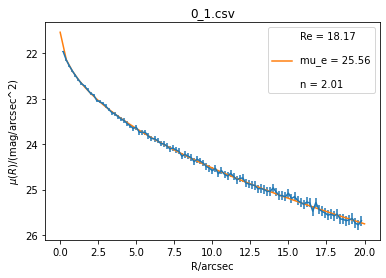

<Figure size 576x432 with 0 Axes>

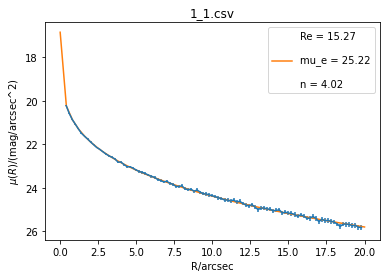

<Figure size 576x432 with 0 Axes>

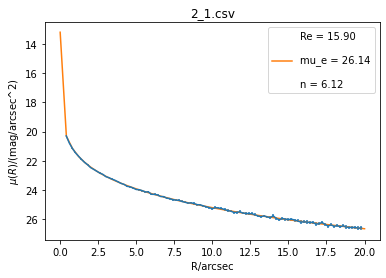

<Figure size 576x432 with 0 Axes>

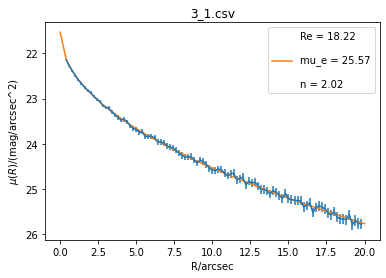

<Figure size 576x432 with 0 Axes>

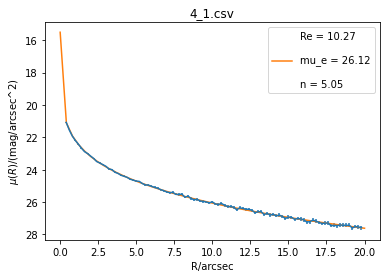

<Figure size 576x432 with 0 Axes>

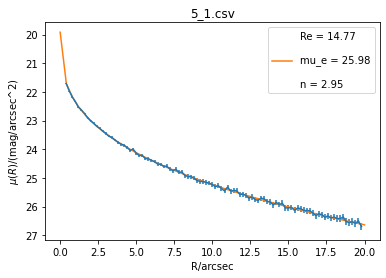

In [17]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params(loc_ls,consider_err=True,output=False,output_plot=True)

### Ignore the mu_err

<Figure size 576x432 with 0 Axes>

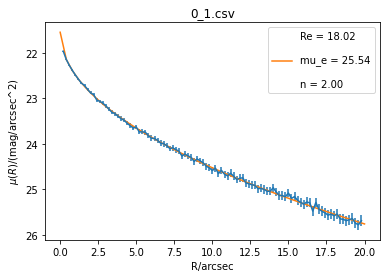

<Figure size 576x432 with 0 Axes>

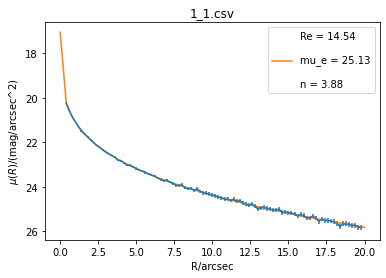

<Figure size 576x432 with 0 Axes>

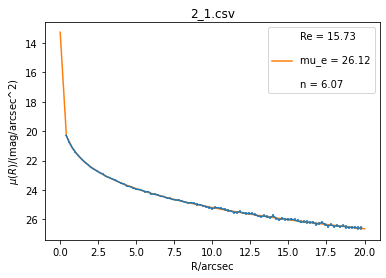

<Figure size 576x432 with 0 Axes>

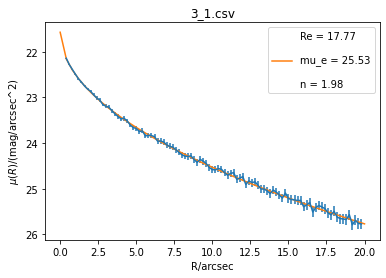

<Figure size 576x432 with 0 Axes>

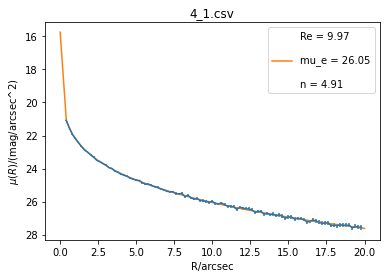

<Figure size 576x432 with 0 Axes>

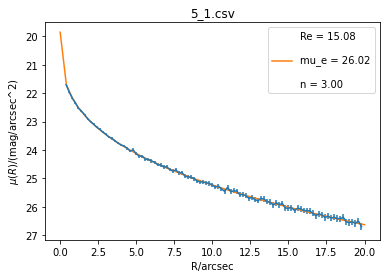

In [18]:
loc_ls=[str(i)+'_1.csv' for i in range(0,6)]
result=get_sersic_params(loc_ls,consider_err=False,output=False,output_plot=True)

# Appendix
**A prove**

From this formular
$$\mu_0-M_\odot-5log(D/10pc)=-2.5log(\frac{I_0}{L_{\odot}/arcsec^2})\tag{1}$$

We can get $\frac{I_0}{L_\odot/arcsec^2}=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times D^2/(10pc)^2$. So the luminosity is
$$\frac{L}{L_\odot}\propto\frac{I_0}{L_\odot/arcsec^2}\times (\frac{R_e}{arcsec})^2=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times D^2/(10pc)^2\times (\frac{R_e}{arcsec^2})^2$$

From this formular
$$\mu_0=-2.5log(\frac{I_0}{L_\odot pc^{-2}})+21.572+M_\odot\tag{2}$$

We can get $\frac{I_0}{L_\odot/pc^2}=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times 10^{\frac{21.572}{2.5}}$
$$\frac{L}{L_\odot}\propto\frac{I_0}{L_\odot/pc^2}\times (\frac{R_e}{arcsec})^2 \times (\frac{2\pi}{360*60*60arcsec})^2 \times D^2=10^{\frac{1}{-2.5}(\mu_0-M_\odot)}\times D^2\times 10^{\frac{21.572}{2.5}}\times (\frac{2\pi}{360*60*60arcsec})^2 \times (\frac{R_e}{arcsec^2})^2$$

**since**
$$10^{\frac{21.572}{2.5}}\times (\frac{2\pi}{360*60*60})^2\approx\frac{1}{100}$$

**So, the two formulars (1) & (2)  are the same!**